## 번역기를 만들어보자

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

### (1) 데이터 전처리

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
21361,Leave that to me.,Laisse-moi ça !,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
149102,He is an archeologist's assistant.,C'est un assistant en archéologie.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
131309,It's awfully cold this evening.,Comment on se les pèle ce soir.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
10372,Don't be hasty.,Ne te précipite pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
123424,In what country were you born?,Dans quel pays es-tu né ?,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


세번째 열은 불필요하므로 제거하고, 훈련 데이터는 5만개의 샘플로 줄이겠습니다.

In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
2473,Stop lying.,Arrêtez de mentir.
37551,Are things that bad?,Les choses sont-elles si mauvaises ?
19398,He laughed at me.,Il me rit au nez.
15293,I prefer biking.,Je préfère faire du vélo.
12403,Stop sniffling.,Arrêtez de renifler.


In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample()

전체 샘플의 수 : 50000


,eng,fra
841,Try some.,\t Essaie. \n


In [5]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 4, 7], [19, 4, 7], [19, 4, 7]]

In [6]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [7]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [9]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


In [10]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [11]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


In [12]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [13]:
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


In [15]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


### (2) 모델 훈련하기

In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

print('⏳')

⏳


In [17]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [18]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 316416      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [21]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 11s 20ms/step - loss: 0.9393 - val_loss: 0.7992
Epoch 2/50
368/368 [==============================] - 6s 17ms/step - loss: 0.5851 - val_loss: 0.6819
Epoch 3/50
368/368 [==============================] - 6s 17ms/step - loss: 0.4914 - val_loss: 0.5934
Epoch 4/50
368/368 [==============================] - 6s 18ms/step - loss: 0.4312 - val_loss: 0.5410
Epoch 5/50
368/368 [==============================] - 6s 17ms/step - loss: 0.3903 - val_loss: 0.5012
Epoch 6/50
368/368 [==============================] - 6s 18ms/step - loss: 0.3607 - val_loss: 0.4728
Epoch 7/50
368/368 [==============================] - 6s 18ms/step - loss: 0.3383 - val_loss: 0.4455
Epoch 8/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3205 - val_loss: 0.4362
Epoch 9/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3056 - val_loss: 0.4175
Epoch 10/50
368/368 [==============================] - 7s 18ms/step - loss: 0.2933 - val_l

###  (3) 모델 테스트하기

테스트 단계에서의 디코더의 동작 순서
 - 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
 - <sos> 토큰인 '\t'를 디코더에 입력한다.
 - 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다.
 - 3을 반복하다가 <eos> 토큰인 '\n'이 예측되면 이를 중단한다.

In [22]:
#인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [23]:
#디코더 정의
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [24]:
#디코더의 재출력 재설계
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

In [25]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [26]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [27]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  contrôle-toi. 
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  salut ! 
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  comparse-toi ! 
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Au revoir. 
번역기가 번역한 문장:  au lait. 
-----------------------------------
입력 문장: Hands off.
정답 문장:  Pas touche ! 
번역기가 번역한 문장:  taissez-vous ! 


## 프로젝트 : 단어 Level로 번역기 업그레이드하기

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다

#### 주요 라이브러리 버전을 확인

In [28]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [29]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
75641,Who are they talking to?,À qui sont-ils en train de parler ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
140940,What problems did they run into?,Quels problèmes ont-elles rencontrés ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
140155,Tom could've hurt himself today.,Tom aurait pu se blesser aujourd'hui.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
32938,I tried not to cry.,J'ai essayé de ne pas pleurer.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
189929,My name is known to everybody in my school.,Mon nom est connu de tous dans mon école.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [30]:
lines = lines[['eng', 'fra']][:33000] # 3만3천개 샘플 사용 
lines.sample(5)

,eng,fra
6094,Thanks a lot.,Mille mercis.
18919,Do you like that?,Ça te plaît ?
19272,Have some coffee.,Prends du café !
7006,Can you pitch?,Sais-tu lancer ?
22893,Tom stepped away.,Tom démissionna.


3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용

### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

1. 구두점(Punctuation)을 단어와 분리해주세요.
2. 소문자로 바꿔주세요.
3. 띄어쓰기 단위로 토큰화를 수행하세요.

In [31]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 4, 7], [19, 4, 7], [19, 4, 7]]

In [32]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[17, 5, 1, 29], [13, 5, 10, 14, 26, 2, 11], [2, 7, 1, 10, 8, 9, 4, 2, 1, 29]]

In [33]:
import re

def preprocess_lines(lines):
    # 구두점(Punctuation)을 단어와 분리
    lines['eng'] = lines['eng'].apply(lambda x: re.sub(r"([.,!?])", r" \1 ", x))
    lines['fra'] = lines['fra'].apply(lambda x: re.sub(r"([.,!?])", r" \1 ", x))

    # 소문자로 변환
    lines['eng'] = lines['eng'].apply(lambda x: x.lower())
    lines['fra'] = lines['fra'].apply(lambda x: x.lower())

    # 띄어쓰기 단위로 토큰화
    lines['eng'] = lines['eng'].apply(lambda x: x.split())
    lines['fra'] = lines['fra'].apply(lambda x: x.split())

    return lines

In [34]:
# 참고
#import os, re

# def preprocess_sentence(sentence):
# sentence = sentence.lower().strip() # 1. 소문자로, 공백 없애기
# sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백
# sentence = sentence.strip() # 5. 양쪽 공백 지우기. 1번에서도 공백 없애기 했는데 두번째이네
# sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개 공백은 공백 하나로

# return sentence

In [35]:
# lines 데이터프레임에 작업을 수행
lines = preprocess_lines(lines[['eng', 'fra']][:33000])

# 샘플 출력
sample = lines.sample(5)
print(sample)

                             eng                                 fra
29866  [where, do, we, start, ?]            [où, commençons-nous, ?]
12658       [they're, trying, .]      [elles, font, des, efforts, .]
16382    [my, hair, is, gray, .]       [mes, cheveux, sont, gris, .]
23998   [you, need, to, stop, .]  [il, faut, que, vous, arrêtiez, .]
24068    [you're, a, monster, .]        [vous, êtes, un, monstre, .]


In [36]:
lines[['eng', 'fra']][:-5] 

,eng,fra
0,"[go, .]","[va, !]"
1,"[go, .]","[marche, .]"
2,"[go, .]","[en, route, !]"
3,"[go, .]","[bouge, !]"
4,"[hi, .]","[salut, !]"
...,...,...
32990,"[i, want, to, kiss, tom, .]","[je, veux, embrasser, tom, .]"
32991,"[i, want, to, kiss, you, .]","[je, veux, t'embrasser, .]"
32992,"[i, want, to, kiss, you, .]","[je, veux, vous, embrasser, .]"
32993,"[i, want, to, know, now, .]","[je, veux, le, savoir, maintenant, .]"


### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [37]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x: '\t' + ' '.join(x) + ' \n')  # 리스트를 문자열로 변환하여 연결

print('전체 샘플의 수:', len(lines))
lines.sample(5)

전체 샘플의 수: 33000


,eng,fra
7915,"[i, was, at, home, .]",\tj'étais chez moi . \n
15712,"[i'm, not, a, thief, .]",\tje ne suis pas une voleuse . \n
22720,"[tom, is, uninsured, .]",\ttom n'est pas assuré . \n
13529,"[yes, ,, we, can, go, .]","\toui , nous pouvons partir . \n"
5344,"[i'll, get, one, .]",\tje vais en avoir un . \n


In [38]:
lines[['eng', 'fra']][:-5]

,eng,fra
0,"[go, .]",\tva ! \n
1,"[go, .]",\tmarche . \n
2,"[go, .]",\ten route ! \n
3,"[go, .]",\tbouge ! \n
4,"[hi, .]",\tsalut ! \n
...,...,...
32990,"[i, want, to, kiss, tom, .]",\tje veux embrasser tom . \n
32991,"[i, want, to, kiss, you, .]",\tje veux t'embrasser . \n
32992,"[i, want, to, kiss, you, .]",\tje veux vous embrasser . \n
32993,"[i, want, to, know, now, .]",\tje veux le savoir maintenant . \n


### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [39]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:5]

[[24, 1], [24, 1], [24, 1], [24, 1], [769, 1]]

In [40]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:5]

[[9, 19, 5, 1, 31, 1, 10],
 [9, 15, 5, 12, 16, 28, 2, 1, 13, 1, 10],
 [9, 2, 7, 1, 12, 8, 11, 4, 2, 1, 31, 1, 10],
 [9, 26, 8, 11, 27, 2, 1, 31, 1, 10],
 [9, 3, 5, 14, 11, 4, 1, 31, 1, 10]]

In [41]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4648
프랑스어 단어장의 크기 : 70


In [42]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 61


In [43]:
# 데이터 최종확인
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4648
프랑스어 단어장의 크기 : 70
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 61


In [44]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [45]:
print(decoder_input[:3])
print(decoder_target[:3])

[[9, 19, 5, 1, 31, 1], [9, 15, 5, 12, 16, 28, 2, 1, 13, 1], [9, 2, 7, 1, 12, 8, 11, 4, 2, 1, 31, 1]]
[[19, 5, 1, 31, 1, 10], [15, 5, 12, 16, 28, 2, 1, 13, 1, 10], [2, 7, 1, 12, 8, 11, 4, 2, 1, 31, 1, 10]]


In [46]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 61)
프랑스어 출력데이터의 크기(shape) : (33000, 61)


In [47]:
print(encoder_input[0])

[24  1  0  0  0  0  0  0]


In [48]:
n_of_test = 3000

encoder_input_train = encoder_input[:-n_of_test]
decoder_input_train = decoder_input[:-n_of_test]
decoder_target_train = decoder_target[:-n_of_test]

encoder_input_test = encoder_input[-n_of_test:]
decoder_input_test = decoder_input[-n_of_test:]
decoder_target_test = decoder_target[-n_of_test:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 61)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 61)


### Step 4. 임베딩 층(Embedding layer) 사용하기

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만, 디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 한다는 것입니다!

In [50]:
# from tensorflow.keras.layers import Input, Embedding, Masking

# vocab_size = 30000
# output_dim = 128

# # 인코더에서 사용할 임베딩 층 사용 예시
# encoder_inputs = Input(shape=(None,))
# enc_emb =  Embedding(vocab_size, output_dim)(encoder_inputs)
# encoder_lstm = LSTM(units=256, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [51]:
from tensorflow.keras.layers import Input, Embedding, Masking
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 30000
output_dim = 128

# Define the encoder model
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, output_dim)(encoder_inputs)
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [52]:
# 훈련용 디코더 모델 정의
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=[state_h, state_c])

In [53]:
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Step 5. 모델 구현하기

#### Train 데이터

In [54]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    17920       input_6[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    3840000     input_5[0][0]                    
____________________________________________________________________________________________

In [55]:
# 모델 훈련
model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          callbacks=[early_stopping], epochs=10)

Epoch 1/10
938/938 [==============================] - 17s 14ms/step - loss: 0.7478 - acc: 0.7932 - val_loss: 0.6447 - val_acc: 0.8065
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.4587 - acc: 0.8633 - val_loss: 0.5169 - val_acc: 0.8457
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.3744 - acc: 0.8882 - val_loss: 0.4473 - val_acc: 0.8670
Epoch 4/10
938/938 [==============================] - 12s 12ms/step - loss: 0.3256 - acc: 0.9022 - val_loss: 0.4121 - val_acc: 0.8771
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2912 - acc: 0.9121 - val_loss: 0.3903 - val_acc: 0.8837
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2646 - acc: 0.9197 - val_loss: 0.3735 - val_acc: 0.8890
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.2425 - acc: 0.9261 - val_loss: 0.3622 - val_acc: 0.8923
Epoch 8/10
938/938 [==============================] - 11s 12ms

In [56]:
# 여기서 자꾸 shape 에러가 나서 확인해보자.
# 입력 데이터의 차원 확인
# print('encoder_input_train shape:', encoder_input_train.shape)
# print('decoder_input_train shape:', decoder_input_train.shape)
# print('decoder_target_train shape:', decoder_target_train.shape)
# print('encoder_input_test shape:', encoder_input_test.shape)
# print('decoder_input_test shape:', decoder_input_test.shape)
# print('decoder_target_test shape:', decoder_target_test.shape)

Text(0.5, 1.0, 'Validation_loss')

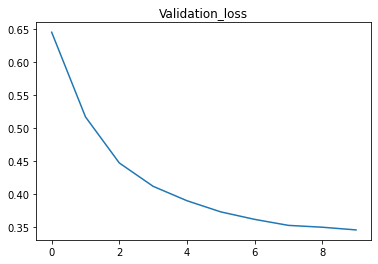

In [57]:
# validation_loss를 시각화해보자
import matplotlib.pyplot as plt

# 손실 함수 그래프
plt.plot(model.history.history['val_loss'])

plt.title('Validation_loss')

#### Test 데이터

In [58]:
#인코더
encoder_model = Model(inputs = encoder_inputs, outputs = [state_h, state_c])
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         3840000   
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 394240    
Total params: 4,234,240
Trainable params: 4,234,240
Non-trainable params: 0
_________________________________________________________________


In [59]:
#디코더
decoder_state_input_h = Input(shape=(256,)) #hidden state
decoder_state_input_c = Input(shape=(256,)) #cell state
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [60]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    17920       input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [61]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

### Step 6. 모델 평가하기

In [62]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [63]:
import numpy as np

def translate_sentences(sentences):
    results = []
    for seq_index in range(len(sentences)):
        input_seq = encoder_input[seq_index: seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)
        results.append(decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 결과에 추가

    return results

sentences = [10, 25, 90, 290] # 번역할 문장의 인덱스 (자유롭게 선택해 보세요)
translations = translate_sentences(sentences)

for i in range(len(sentences)):
    seq_index = sentences[i]
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력


-----------------------------------
입력 문장: ['run', '!']
정답 문장: filez ! 
-----------------------------------
입력 문장: ['wow', '!']
정답 문장: wah ! 
-----------------------------------
입력 문장: ['cheers', '!']
정답 문장: tchin-tchin ! 
-----------------------------------
입력 문장: ['go', 'back', '.']
정답 문장: recule . 


## 회고

이번 노드를 통해 NLP로 번역 과정을 두 가지 방법으로 구현해 보았다.
첫 번째는 to_categorical() 함수로 정수형 레이블을 다중 클래스 분류 모델의 출력 형식에 맞게 원한 인코딩으로 된 이진 벡터를 사용했다. 두 번째 프로젝트에서는 임베딩 층을 추가하면서 텍스트 데이터를 고차원 벡터로 표현하였다. 결과는 파파고로 번역을 해보았을 때 100% 정확하진 않았지만 그래도 노력한 만큼 값이 나온 것 같다.

https://wikidocs.net/22888

https://sophihappy.tistory.com/2

https://ponyozzang.tistory.com/335

https://tykimos.github.io/2018/09/14/ten-minute_introduction_to_sequence-to-sequence_learning_in_Keras/